In [1]:
import pandas as pd
import numpy as np

import re

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve
#from catboost import Pool, CatBoostClassifier

from scipy.stats import pearsonr, chi2_contingency
from itertools import combinations
from statsmodels.stats.proportion import proportion_confint

In [2]:
data = pd.read_csv(
    '/Users/reejungkim/Documents/Git/loan_data_2007_2014.csv',
    parse_dates=['issue_d'], infer_datetime_format=True)

#data = data[(data.issue_d >= '2018-01-01 00:00:00') & (data.issue_d < '2019-01-01 00:00:00')]
data = data.reset_index(drop=True)
data.head()

/Users/reejungkim/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3156: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# EDA

In [3]:
data.columns
#data.info()

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose',
       'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
       'next_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med',
       'mths_since_last_major_derog', 'policy_code', 'application_type',
       'annual_inc_joint', 'dti_joint', 'verification_status_joint',
    

In [4]:
data.shape

(466285, 74)

### define bad

In [5]:
data.loan_status.unique()

array(['Fully Paid', 'Charged Off', 'Current', 'Default',
       'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

In [6]:
data['good_bad'] = np.where( (data['loan_status']=='Default') 
                            | (data['loan_status']=='Late (16-30 days)') 
                            | (data['loan_status']=='Late (31-120 days)'), 
                            'bad', 'good')

In [7]:
import plotly.offline as py 
py.init_notebook_mode(connected=True) # this code, allow us to work with offline plotly version
import plotly.graph_objs as go # it's like "plt" of matplot
import plotly.tools as tls # It's useful to we get some tools of plotly
import warnings # This library will be used to ignore some warnings
from collections import Counter # To do counter of some features

trace0 = go.Bar(
            x = data[data["good_bad"]== 'good']["good_bad"].value_counts().index.values,
            y = data[data["good_bad"]== 'good']["good_bad"].value_counts().values,
            name='Good credit'
    )

trace1 = go.Bar(
            x = data[data["good_bad"]== 'bad']["good_bad"].value_counts().index.values,
            y = data[data["good_bad"]== 'bad']["good_bad"].value_counts().values,
            name='Bad credit'
    )

d = [trace0, trace1]

layout = go.Layout(
    
)

layout = go.Layout(
    yaxis=dict(
        title='Count'
    ),
    xaxis=dict(
        title='Risk Variable'
    ),
    title='Target variable distribution'
)

fig = go.Figure(data=d, layout=layout)

py.iplot(fig, filename='grouped-bar')

data.describe().transpose()

### check missing values

In [8]:
percent_missing = data.isnull().sum() * 100 / len(data)
missing_value_df = pd.DataFrame({'column_name': data.columns,
                                 'percent_missing': percent_missing.round(2)})
missing_value_df.sort_values('percent_missing', inplace=True)

In [9]:
missing_value_df

,column_name,percent_missing
id,id,0.0
zip_code,zip_code,0.0
addr_state,addr_state,0.0
dti,dti,0.0
revol_bal,revol_bal,0.0
...,...,...
open_il_6m,open_il_6m,100.0
open_acc_6m,open_acc_6m,100.0
verification_status_joint,verification_status_joint,100.0
il_util,il_util,100.0


In [10]:
(missing_value_df['percent_missing'] == 100.00).sum()

17

In [11]:
# List of columns having NULL values
missing_values_columns = missing_value_df[(missing_value_df['percent_missing'] == 100.00)].column_name.tolist()

In [12]:
missing_values_columns

['dti_joint',
 'total_cu_tl',
 'inq_fi',
 'inq_last_12m',
 'all_util',
 'max_bal_bc',
 'open_rv_24m',
 'open_rv_12m',
 'total_bal_il',
 'mths_since_rcnt_il',
 'open_il_24m',
 'open_il_12m',
 'open_il_6m',
 'open_acc_6m',
 'verification_status_joint',
 'il_util',
 'annual_inc_joint']

In [13]:
#Dropping columns having all missing values
null_columns_dropped_data = data.drop(missing_values_columns, axis=1)

In [14]:
(missing_value_df['percent_missing'] >= 50.00).sum()

21

### drop columns where more than half of data are missed

In [15]:
column_list_to_drop = missing_value_df[(missing_value_df['percent_missing'] >= 50.00)].column_name.tolist()

In [16]:
data = data.drop(column_list_to_drop, axis=1)

In [17]:
data.shape

(466285, 54)

In [18]:
data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,good_bad
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,...,NaN,Jan-16,0.0,1,INDIVIDUAL,0.0,NaN,NaN,NaN,good
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,...,NaN,Sep-13,0.0,1,INDIVIDUAL,0.0,NaN,NaN,NaN,good
2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,...,NaN,Jan-16,0.0,1,INDIVIDUAL,0.0,NaN,NaN,NaN,good
3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,...,NaN,Jan-15,0.0,1,INDIVIDUAL,0.0,NaN,NaN,NaN,good
4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,...,Feb-16,Jan-16,0.0,1,INDIVIDUAL,0.0,NaN,NaN,NaN,good


In [19]:
data.columns.to_list()

['id',
 'member_id',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'url',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'next_pymnt_d',
 'last_credit_pull_d',
 'collections_12_mths_ex_med',
 'policy_code',
 'application_type',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal',
 'total_rev_hi_lim',
 'good_bad']

### unique values per column

In [20]:
count_unique = []
for row in data.columns.tolist():
    count_unique.append({'column': row, 'count': len(data[row].unique())})

In [21]:
pd.DataFrame(count_unique).sort_values('count')

,column,count
48,application_type,1
47,policy_code,1
53,good_bad,2
5,term,2
32,initial_list_status,2
17,pymnt_plan,2
14,verification_status,3
12,home_ownership,6
49,acc_now_delinq,7
8,grade,7


In [22]:
#data.loan_status.unique()
data.loan_status.value_counts()

Current                                                224226
Fully Paid                                             184739
Charged Off                                             42475
Late (31-120 days)                                       6900
In Grace Period                                          3146
Does not meet the credit policy. Status:Fully Paid       1988
Late (16-30 days)                                        1218
Default                                                   832
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

In [23]:
data.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'pymnt_plan', 'url', 'purpose', 'title',
       'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv',
       'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'policy_code', 'application_type',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim',
       'good_bad'],
      dtype='object')

### Distributions

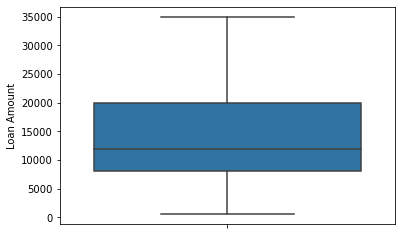

In [24]:
sns.boxplot( y=data["loan_amnt"] )
plt.ylabel('Loan Amount')
plt.show()

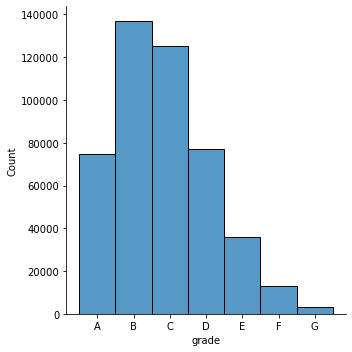

In [25]:
sns.displot(data.sort_values('grade'), x='grade')

In [26]:
data['grade'].value_counts()

B    136929
C    125293
D     76888
A     74867
E     35757
F     13229
G      3322
Name: grade, dtype: int64

In [27]:

# explore the unique values in loan_status column
data['grade'].value_counts(normalize = True)

B    0.293659
C    0.268705
D    0.164895
A    0.160561
E    0.076685
F    0.028371
G    0.007124
Name: grade, dtype: float64

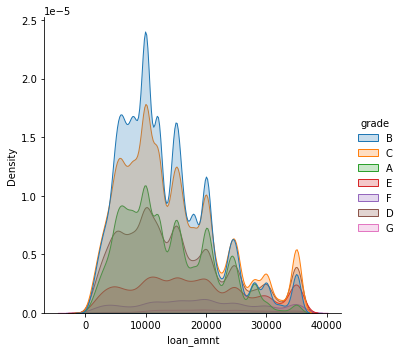

In [28]:
sns.displot(data, x='loan_amnt', kind='kde', hue='grade', fill=True)

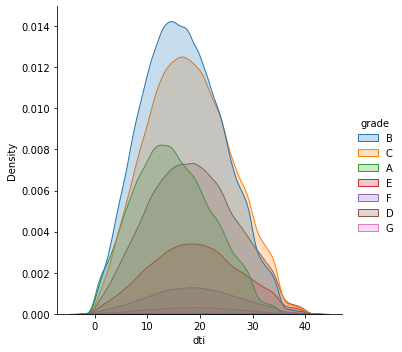

In [29]:
sns.displot(data, x='dti', kind='kde', hue='grade', fill=True)

<module 'matplotlib.pyplot' from '/Users/reejungkim/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/matplotlib/pyplot.py'>

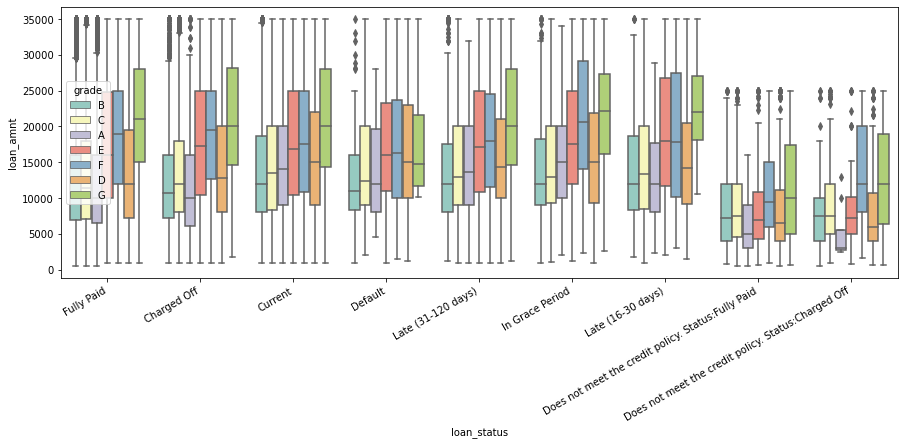

In [30]:

plt.figure(figsize=(15,5))

sns.boxplot(x="loan_status", y="loan_amnt",  hue="grade",
                 data=data, palette="Set3")

#plt.xticks(rotation=45)
plt.setp(plt.xticks()[1], rotation=30, ha='right') #ha = horizonalalignment
plt

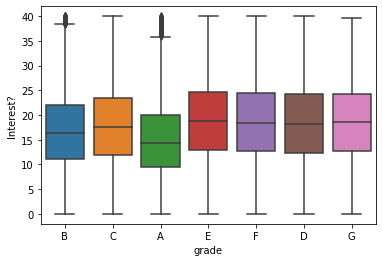

In [31]:
sns.boxplot(y='dti', x='grade', data=data)
plt.ylabel('Interest?')
plt.show()

sns.pairplot(data)

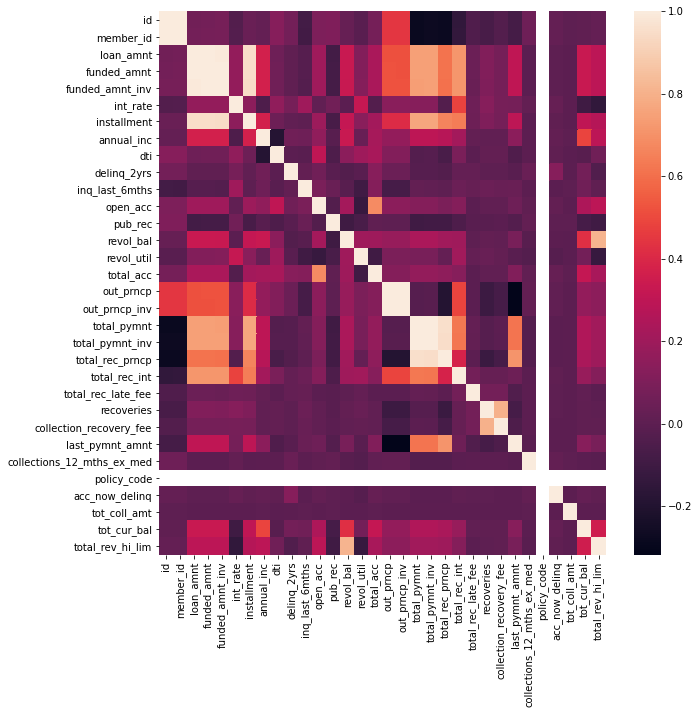

In [32]:
plt.figure(figsize=(10,10))
sns.heatmap(data.corr())
plt.show()

In [33]:
data.loan_status.unique()

array(['Fully Paid', 'Charged Off', 'Current', 'Default',
       'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

In [34]:
X = data.drop('good_bad', axis = 1)
y = data['good_bad']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, 
                                                    random_state = 42, stratify = y)

In [35]:
data

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,good_bad
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,...,NaN,Jan-16,0.0,1,INDIVIDUAL,0.0,NaN,NaN,NaN,good
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,...,NaN,Sep-13,0.0,1,INDIVIDUAL,0.0,NaN,NaN,NaN,good
2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,...,NaN,Jan-16,0.0,1,INDIVIDUAL,0.0,NaN,NaN,NaN,good
3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,...,NaN,Jan-15,0.0,1,INDIVIDUAL,0.0,NaN,NaN,NaN,good
4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,...,Feb-16,Jan-16,0.0,1,INDIVIDUAL,0.0,NaN,NaN,NaN,good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466280,8598660,1440975,18400,18400,18400.0,60 months,14.47,432.64,C,C2,...,Feb-16,Jan-16,0.0,1,INDIVIDUAL,0.0,0.0,294998.0,29900.0,good
466281,9684700,11536848,22000,22000,22000.0,60 months,19.97,582.50,D,D5,...,NaN,Jan-16,0.0,1,INDIVIDUAL,0.0,0.0,221830.0,39400.0,good
466282,9584776,11436914,20700,20700,20700.0,60 months,16.99,514.34,D,D1,...,Feb-16,Dec-15,0.0,1,INDIVIDUAL,0.0,0.0,73598.0,13100.0,good
466283,9604874,11457002,2000,2000,2000.0,36 months,7.90,62.59,A,A4,...,NaN,Apr-15,0.0,1,INDIVIDUAL,0.0,0.0,591610.0,53100.0,good


sns.displot(data, x='loan_amnt', kind='kde', hue='good_bad', fill=False)

### checking distribution of defaults

In [36]:
data.pivot_table(index='good_bad', columns='grade', aggfunc='count', margins=True, values='loan_amnt')

grade,A,B,C,D,E,F,G,All
good_bad,,,,,,,,
bad,420,1766,2674,2187,1271,489,143,8950
good,74447,135163,122619,74701,34486,12740,3179,457335
All,74867,136929,125293,76888,35757,13229,3322,466285


In [37]:
pd.crosstab(data.good_bad, data.grade, values=data.loan_amnt, aggfunc='count', normalize='columns', margins=True)

grade,A,B,C,D,E,F,G,All
good_bad,,,,,,,,
bad,0.00561,0.012897,0.021342,0.028444,0.035545,0.036964,0.043046,0.019194
good,0.99439,0.987103,0.978658,0.971556,0.964455,0.963036,0.956954,0.980806


In [38]:
pd.crosstab(data.good_bad, data.grade, values=data.loan_amnt, aggfunc=np.sum, normalize='index', margins=True)#.applymap(lambda x: "{0:.0f}%".format(100*x))

grade,A,B,C,D,E,F,G
good_bad,,,,,,,
bad,0.043457,0.169877,0.282696,0.250436,0.167085,0.064863,0.021586
good,0.152543,0.271217,0.266112,0.171833,0.092356,0.035924,0.010015
All,0.150267,0.269103,0.266458,0.173473,0.093916,0.036527,0.010256


In [39]:
data.pivot_table(index='good_bad', columns='grade', margins=True, values='loan_amnt', aggfunc=np.sum)

grade,A,B,C,D,E,F,G,All
good_bad,,,,,,,,
bad,6052775,23661000,39374875,34881525,23272150,9034400,3006575,139283300
good,997117050,1772853200,1739479300,1123214050,603701925,234820475,65462475,6536648475
All,1003169825,1796514200,1778854175,1158095575,626974075,243854875,68469050,6675931775
